In [10]:
import numpy as np
import pandas as pd
import tempfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, classification_report,
    confusion_matrix, f1_score
)
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

In [13]:
df = pd.read_csv("C:\\Users\\user\\Downloads\\market classification project using TCN on interaday Gold data\\hourly features formula one.csv")
print(df)

      Unnamed: 0              date     open     high      low    close  \
0              0    4/22/2025 3:00  3471.10  3475.10  3466.80  3475.10   
1              1    4/22/2025 4:00  3472.57  3494.08  3472.28  3487.27   
2              2    4/22/2025 5:00  3487.55  3487.94  3479.20  3484.67   
3              3    4/22/2025 6:00  3484.95  3495.01  3474.14  3493.26   
4              4    4/22/2025 7:00  3492.59  3499.45  3477.36  3479.42   
...          ...               ...      ...      ...      ...      ...   
2937        2937  10/10/2025 11:00  3995.56  3999.84  3990.61  3993.68   
2938        2938  10/10/2025 12:00  3993.50  3999.70  3983.56  3986.96   
2939        2939  10/10/2025 13:00  3987.35  3993.31  3980.01  3985.40   
2940        2940  10/10/2025 14:00  3985.33  3997.99  3975.26  3978.33   
2941        2941  10/10/2025 15:00  3978.64  3993.93  3970.39  3989.12   

      volume  past_ret_1h  past_ret_2h  past_ret_4h  past_ret_8h  \
0         36    -0.046091    -0.046091    -

In [14]:
features_requested = ["open", "1 percent prediction", "past_ret_16h"]

In [15]:
def find_column_variant(name, cols):
    """Return the actual column name in cols that matches requested name (robust to spaces, %, underscores)."""
    if name in cols:
        return name
    norm_target = name.strip().lower().replace("%", "pct").replace(" ", "_")
    for c in cols:
        norm_c = c.strip().lower().replace("%", "pct").replace(" ", "_")
        if norm_c == norm_target:
            return c
    # try contains (fallback)
    for c in cols:
        if norm_target in c.strip().lower().replace("%","pct").replace(" ","_"):
            return c
    raise KeyError(f"Column matching '{name}' not found. Available columns: {cols[:20]}...")

In [16]:
df_work = df.copy()   # uses original df variable from your environment

# find label column robustly
cols = list(df_work.columns)
label_col = None
for candidate in ["forward regime", "forward_regime", "forward-regime", "regime", "label"]:
    try:
        label_col = find_column_variant(candidate, cols)
        break
    except KeyError:
        label_col = None
if label_col is None:
    # fallback: try to find a column containing "forward" or "regime"
    for c in cols:
        if "forward" in c.lower() or "regime" in c.lower():
            label_col = c
            break
if label_col is None:
    raise KeyError("Couldn't find a label column. Make sure a 'forward regime' column exists in your df.")

In [17]:
found_features = []
for req in features_requested:
    try:
        found = find_column_variant(req, cols)
        found_features.append(found)
    except KeyError as e:
        raise KeyError(f"Feature error: {e}")

print("Using features:", found_features)
print("Using label column:", label_col)

Using features: ['open', '1 percent prediction', 'past_ret_16h']
Using label column: forward regime


In [18]:
lab = df_work[label_col]

# If strings like "upward"/"downward"/"range"
if lab.dtype == object or lab.dtype.name.startswith("str"):
    lab_s = lab.astype(str).str.lower().str.strip()
    # define mapping depending on values present
    if lab_s.isin(["upward","up","1"]).any() or lab_s.isin(["downward","down","-1"]).any():
        map_dict = {}
        # common possible tokens
        map_dict.update({k:1 for k in ["upward","up","1","buy","bull"]})
        map_dict.update({k:-1 for k in ["downward","down","-1","sell","bear"]})
        map_dict.update({k:0 for k in ["range","flat","0","neutral"]})
        # map, unknown -> NaN
        mapped = lab_s.map(map_dict)
    else:
        # try numeric parse
        mapped = pd.to_numeric(lab, errors="coerce")
else:
    # numeric already
    mapped = pd.to_numeric(lab, errors="coerce")

# drop rows where label couldn't be mapped
na_before = mapped.isna().sum()
if na_before > 0:
    print(f"Warning: {na_before} rows had unmapped labels and will be dropped.")
mapped = mapped.dropna()
df_work = df_work.loc[mapped.index].copy()
mapped = mapped.loc[mapped.index]

# keep only up (1) and down (-1)
mask_binary = mapped.isin([1, -1])
df_work = df_work.loc[mask_binary].copy()
mapped = mapped.loc[mask_binary]

if df_work.shape[0] == 0:
    raise ValueError("After mapping labels to binary (up/down) there are no rows left. Check your label values.")

# convert mapped labels to binary 0/1 for ML: -1 -> 0, 1 -> 1
y_all = mapped.map({-1: 0, 1: 1}).astype(int)

# final feature matrix (only the selected features, keep original df untouched)
X_all = df_work[found_features].copy()

print("Final dataset shape:", X_all.shape)
print("Label distribution (overall):")
print(y_all.value_counts())


Final dataset shape: (996, 3)
Label distribution (overall):
forward regime
1    551
0    445
Name: count, dtype: int64


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.25, random_state=42, stratify=y_all
)

print("Train label counts:", y_train.value_counts().to_dict())
print("Test label counts:", y_test.value_counts().to_dict())

Train label counts: {1: 413, 0: 334}
Test label counts: {1: 138, 0: 111}


In [24]:
unique = np.unique(y_train)
if len(unique) < 2:
    print("WARNING: only one class present in training set. CatBoost will be trained without class weights.")
    class_weights = None
else:
    cnt_neg = int((y_train == 0).sum())
    cnt_pos = int((y_train == 1).sum())
    # avoid division by zero (shouldn't happen due to stratify)
    if cnt_neg == 0:
        w_neg = 1.0
    else:
        w_neg = cnt_pos / cnt_neg
    w_pos = 1.0
    class_weights = {0: w_neg, 1: w_pos}
print("Class weights:", class_weights)

Class weights: {0: 1.2365269461077844, 1: 1.0}


In [25]:
temp_dir = tempfile.mkdtemp()

model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.02,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=class_weights,
    random_seed=42,
    verbose=200,
    od_type="Iter",
    od_wait=100,
    train_dir=temp_dir,
    save_snapshot=False
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True
)



0:	test: 0.6238086	best: 0.6238086 (0)	total: 160ms	remaining: 5m 18s
200:	test: 0.7025069	best: 0.7043674 (157)	total: 512ms	remaining: 4.58s
400:	test: 0.7295992	best: 0.7296644 (399)	total: 903ms	remaining: 3.6s
600:	test: 0.7494451	best: 0.7504896 (585)	total: 1.25s	remaining: 2.91s
800:	test: 0.7559734	best: 0.7568220 (784)	total: 1.6s	remaining: 2.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7568220394
bestIteration = 784

Shrink model to first 785 iterations.


In [26]:
proba = model.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.05, 0.95, 200)
best_f1 = -1
best_thr = 0.5
for thr in thresholds:
    preds = (proba > thr).astype(int)
    f = f1_score(y_test, preds, pos_label=1)
    if f > best_f1:
        best_f1 = f
        best_thr = thr

print(f"\nBest threshold = {best_thr:.3f}, Best F1 = {best_f1:.4f}\n")

# final preds, metrics
final_preds = (proba > best_thr).astype(int)

print("CONFUSION MATRIX")
print(confusion_matrix(y_test, final_preds))
print("\nCLASSIFICATION REPORT")
print(classification_report(y_test, final_preds))


Best threshold = 0.281, Best F1 = 0.7670

CONFUSION MATRIX
[[ 40  71]
 [  8 130]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.83      0.36      0.50       111
           1       0.65      0.94      0.77       138

    accuracy                           0.68       249
   macro avg       0.74      0.65      0.64       249
weighted avg       0.73      0.68      0.65       249



* precision for sell: 0.83 --> If model says SELL, most of those signals are truly SELL 
* recall for sell: 0.36 --> Out of all true SELL situations in the market, your model captures only 36% of them.
* F1 balances the two:SELL classifier is reasonably precise, but not very complete, resulting in a moderate F1 of 0.50.

* precision for buy: 0.65 --> when model predicts BUY, it is correct 65% of the time.
* recall: 0.94 --> Out of all true BUY moments in the market, your model correctly identifies 94% of them.
* F1 for buy: strong. F1 ends up high because recall is dominant.


Best F1 threshold = 0.281 /
The model is not confident — it predicts "up" unless the probability is VERY low. /
This already tells you: The model learned a bias toward upward moves in your dataset distribution.

model is good at predicting upward movements, and weak at detecting downward moves.

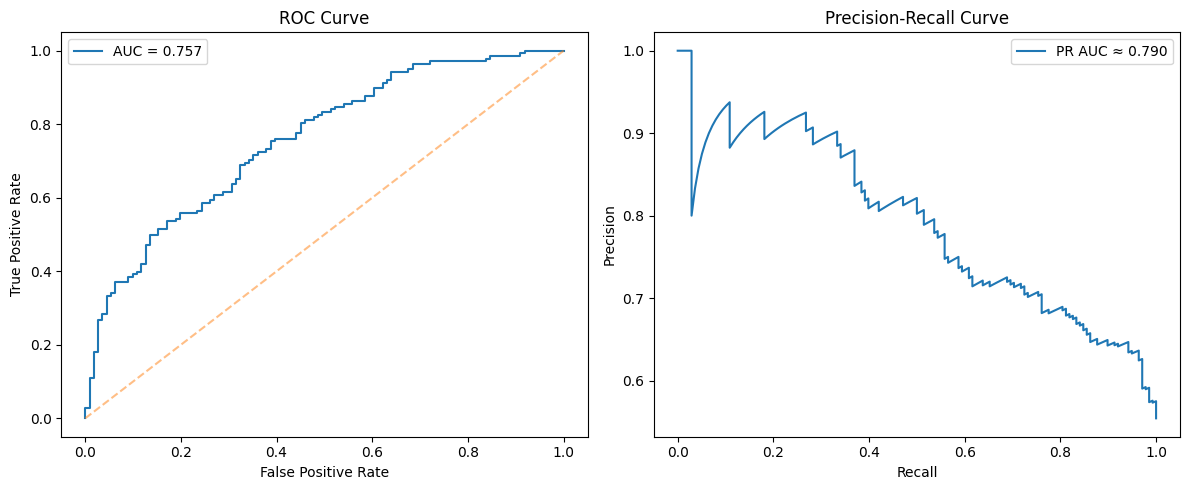

In [27]:
auc_score = roc_auc_score(y_test, proba)
fpr, tpr, _ = roc_curve(y_test, proba)
precision, recall, _ = precision_recall_curve(y_test, proba)
pr_auc = np.trapz(precision[::-1], recall[::-1])  # approximate PR AUC

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1],[0,1],"--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(recall, precision, label=f"PR AUC ≈ {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
feat_imp = model.get_feature_importance()
feat_names = X.columns

df_imp = pd.DataFrame({"feature": feat_names, "importance": feat_imp})
df_imp = df_imp.sort_values("importance", ascending=False)
print("\nTop Feature Importance")
print(df_imp.head(15))


Top Feature Importance
                feature  importance
0                  open   55.029444
2          past_ret_16h   34.533106
1  1 percent prediction   10.437449


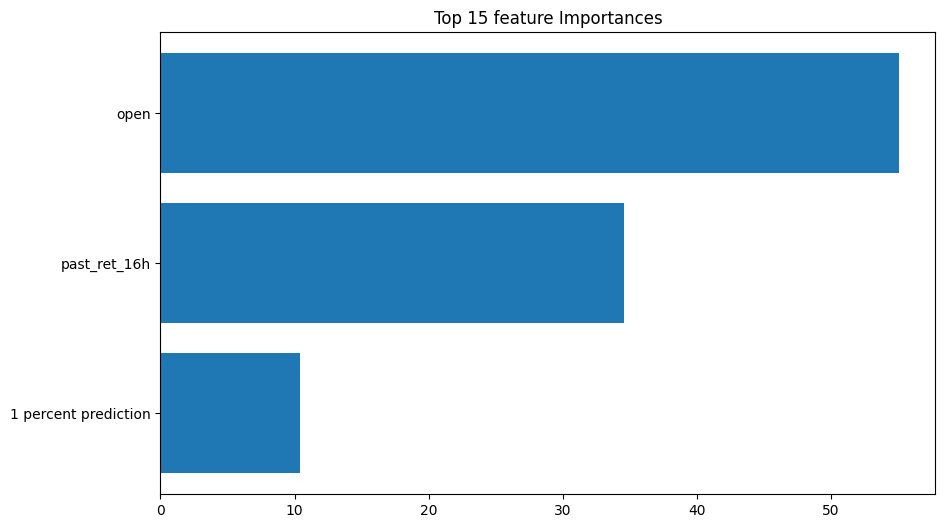

In [29]:
plt.figure(figsize=(10,6))
plt.barh(df_imp["feature"].values[:15], df_imp["importance"].values[:15])
plt.gca().invert_yaxis()
plt.title("Top 15 feature Importances")
plt.show()